In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from geopandas import GeoDataFrame
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [17]:
def obtener_rmse(col_true, col_pred):
    return mean_squared_error(col_true, col_pred)**0.5

In [2]:
propiedades = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/datos para el tp2/set_datos_propiedades.csv')

In [3]:
propiedades.drop(['lat','lon','fecha_de_publicacion', 'expenses', 'state_name',\
                  'distancia_villas', 'description'], axis = 1, inplace = True)
propiedades = propiedades.loc[propiedades.superficie.notnull(),:]

## Convierto los indices con preprocesamiento

In [5]:
barrios = {}
for x in list(propiedades.place_name_encoded):
    if x not in barrios:
        barrios[x] = [x]

In [6]:
tipos = preprocessing.OneHotEncoder()
tipos.fit([[0],[1],[2], [3]]) 

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [7]:
pre_barrios = preprocessing.OneHotEncoder()
pre_barrios.fit(barrios.values())

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [8]:
propiedades.loc[:,'place_name_encoded_2'] = propiedades.loc[:,'place_name_encoded']\
.apply(lambda x: pre_barrios.transform([[x]]))

In [9]:
propiedades.loc[:,'property_type_encoded_2'] = propiedades.loc[:,'property_type_encoded']\
.apply(lambda x: tipos.transform([[x]]))

In [10]:
propiedades.to_csv('/home/agustin/Escritorio/datos_indice.csv', index = False)

In [11]:
entrenar = propiedades.loc[(propiedades.Year >= 2016) & ((propiedades.Month < 6) | (propiedades.Year < 2017)),:]

In [12]:
adivinar = propiedades.loc[(propiedades.Year == 2017) & (propiedades.Month == 6),:]

## Perceptron sin indices de preprocesamiento

In [13]:
def adivinar_precio(fila, perceptron):
    return  perceptron.predict([fila])[0]

In [5]:
condiciones = ['place_name_encoded', 'property_type_encoded', 'superficie', 'gimnasio',\
               'pileta', 'seguridad']

precios = condiciones + ['price_aprox_usd']

In [15]:
funcion = ['adam', 'lbfgs', 'sgd']
activacion = ['relu','identity', 'logistic', 'tanh']
tolerancia = [1e-5, 1e-8, 1e-10]

In [19]:
impresion = []
for i in range (0, len(funcion)):
    for j in range(0, len(activacion)):
        for k in range(0, len(tolerancia)):
            perceptron = MLPRegressor(solver = funcion[i], activation = activacion[j], tol = tolerancia[k])
            perceptron.fit(entrenar.loc[:,condiciones], entrenar.loc[:, 'price_aprox_usd'])
            adivinar.loc[:,'precio_adivinado_perceptron'] = adivinar.loc[:, condiciones]\
            .apply(lambda x: adivinar_precio(x, perceptron), axis = 1)
            error = obtener_rmse(adivinar.loc[:,'price_aprox_usd'], adivinar.loc[:,'precio_adivinado_perceptron'])
            impresion.append((funcion[i], activacion[j], tolerancia[k], error))

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [21]:
for i in range (0, len(impresion)):
    print("Funcion = {} , activacion = {}, tolerancia = {}, error = {}".format(impresion[i][0], impresion[i][1], impresion[i][2], impresion[i][3]))

Funcion = adam , activacion = relu, tolerancia = 1e-05, error = 2856923.30569
Funcion = adam , activacion = relu, tolerancia = 1e-08, error = 7885404.28854
Funcion = adam , activacion = relu, tolerancia = 1e-10, error = 983892.01563
Funcion = adam , activacion = identity, tolerancia = 1e-05, error = 8068786.87283
Funcion = adam , activacion = identity, tolerancia = 1e-08, error = 6847308.97947
Funcion = adam , activacion = identity, tolerancia = 1e-10, error = 7189725.68045
Funcion = adam , activacion = logistic, tolerancia = 1e-05, error = 446011.124687
Funcion = adam , activacion = logistic, tolerancia = 1e-08, error = 446001.878031
Funcion = adam , activacion = logistic, tolerancia = 1e-10, error = 446003.376714
Funcion = adam , activacion = tanh, tolerancia = 1e-05, error = 445965.857984
Funcion = adam , activacion = tanh, tolerancia = 1e-08, error = 445964.564555
Funcion = adam , activacion = tanh, tolerancia = 1e-10, error = 445965.56429
Funcion = lbfgs , activacion = relu, toler

#### Algunos de sgd no corrieron porque tiraron error. El mejor resultado se obtuvo con solver = lbfgs, activation = logistic y tol = 1e-8

## Corro nuevamente lbfgs pero con iteraciones de aprendizaje

### Hay que volver a correr este for porque estaban mal puestas unas cosas

In [30]:
impresion_2 = []
for k in range(0, len(tolerancia)):
        perceptron = MLPRegressor(solver = 'lbfgs', activation = 'logistic', tol = tolerancia[k], warm_start = True)
        for j in range(15):
            perceptron.fit(entrenar.loc[:,condiciones], entrenar.loc[:, 'price_aprox_usd'])
        adivinar.loc[:,'precio_adivinado_perceptron'] = adivinar.loc[:, condiciones]\
        .apply(lambda x: adivinar_precio(x, perceptron), axis = 1)
        error = obtener_rmse(adivinar.loc[:,'price_aprox_usd'], adivinar.loc[:,'precio_adivinado_perceptron'])
        impresion_2.append(('lbfgs', 'logistic', tolerancia[k], error))

In [35]:
for i in range (0, len(impresion_2)):
    print("Funcion = {} , activacion = {}, tolerancia = {}, error = {}".format(impresion_2[i][0], impresion_2[i][1], impresion_2[i][2], impresion_2[i][3]))
    #print("Funcion = {} , activacion = {}, tolerancia = {}, error = {}".format(impresion_2[i]))

Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 382484.759296
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 366278.527203
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 372085.137759
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 387250.796766
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 386603.813958
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 362685.361738
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 387277.970228
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 390202.417379
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 388526.83776
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 390648.786318
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 387622.53528
Funcion = lbfgs , activacion = logistic, tolerancia = 1e-05, error = 383262.820562
Funcio

In [43]:
def obtener_lista_errores(lista, inicio, fin):
    l = []
    for i in range (inicio, fin):
        l.append(lista[i][-1])
    return l

In [53]:
error_5 = obtener_lista_errores(impresion_2, 0, 15)
error_8 = obtener_lista_errores(impresion_2, 15, 30)
error_10 = obtener_lista_errores(impresion_2, 30, 45)
eje_x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

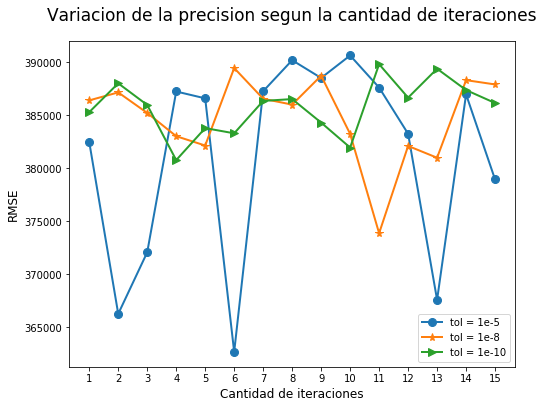

In [171]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelsize'] = 12

plot = plt.figure(figsize = (8, 6))
plt.title("Variacion de la precision segun la cantidad de iteraciones")
plt.plot(eje_x, error_5, marker = 'o', markersize = 8, linewidth = 2, label = "tol = 1e-5")
plt.plot(eje_x, error_8, marker = '*', markersize = 8, linewidth = 2, label = "tol = 1e-8")
plt.plot(eje_x, error_10, marker = '>', markersize = 8, linewidth = 2, label = "tol = 1e-10")
plt.xticks(eje_x);
plt.xlabel('Cantidad de iteraciones')
plt.ylabel('RMSE')
plt.legend(loc='lower right')
plt.show()

#### Despues veo de ejecutar con los indices de preprocesamiento. Pero seguro tarde mucho tiempo mas

## Calculo con los verdaderos datos con indices simples

In [4]:
entrenar = propiedades.loc[(propiedades.Year >= 2016) & ((propiedades.Month >= 6) | (propiedades.Year == 2017)),:]

In [8]:
perceptron = MLPRegressor(solver = 'lbfgs', activation = 'logistic', tol=1e-10,  warm_start = True)
for k in range(6):
    perceptron.fit(entrenar.loc[:,condiciones], entrenar.loc[:, 'price_aprox_usd'])

In [9]:
analizar = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/datos para el tp2/properati_dataset_modificado.csv')

In [10]:
analizar.keys()

Index([u'id', u'created_on', u'property_type', u'place_name',
       u'place_with_parent_names', u'state_name', u'lat', u'lon',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'floor', u'rooms',
       u'expenses', u'description', u'seguridad', u'gimnasio', u'aire',
       u'pileta', u'cochera', u'superficie', u'property_type_encoded',
       u'place_name_encoded'],
      dtype='object')

In [12]:
analizar.loc[:,'price_usd'] = analizar.loc[:,condiciones].apply(lambda x: perceptron.predict([x])[0],axis = 1)

In [14]:
analizar.price_usd.describe()

count     14166.000000
mean     273737.920575
std       13839.190497
min      257696.031603
25%      263776.557855
50%      263816.677580
75%      282017.209480
max      296299.883654
Name: price_usd, dtype: float64

In [16]:
resultado = analizar.loc[:,['id','price_usd']]

In [17]:
resultado.to_csv('Perceptron_resultados.csv', index = False)

## Perceptron con los indices de preprocesamiento

In [13]:
def adivinar_precio_indice(fila, perceptron):
    barrio = fila[0]
    tipo = fila[1]
    columnas = fila[2:]
    l =  list(barrio.toarray()[0]) + list(tipo.toarray()[0]) + columnas
    return  perceptron.predict([l])[0]

In [14]:
condiciones = ['place_name_encoded_2', 'property_type_encoded_2', 'superficie', 'gimnasio',\
               'pileta', 'seguridad']

precios = condiciones + ['price_aprox_usd']

In [15]:
funcion = ['adam', 'lbfgs', 'sgd']
activacion = ['relu','identity', 'logistic', 'tanh']
tolerancia = [1e-5, 1e-8, 1e-10]
impresion = []
#max_iter = 500
#warm.....

In [ ]:
X_true = []
Y_true = []
entrenar.reset_index(drop = True, inplace = True)
for i in range(0,len(entrenar)):
    if np.isnan(entrenar.price_aprox_usd[i]):
        continue
    l = list(entrenar.place_name_encoded_2[i].toarray()[0]) + list(entrenar.property_type_encoded_2[i].toarray()[0])
    l.append(entrenar.superficie[i])
    l.append(entrenar.gimnasio[i])
    l.append(entrenar.pileta[i])
    l.append(entrenar.seguridad[i])
    X_true.append(l)
    Y_true.append(entrenar.price_aprox_usd[i])

In [2]:
propiedades.head()

NameError: name 'propiedades' is not defined

In [16]:
for i in range (0, len(funcion)):
    for j in range(0, len(activacion)):
        for k in range(0, len(tolerancia)):
            perceptron = MLPRegressor(solver = funcion[i], activation = activacion[j], tol = tolerancia[k])
            perceptron.fit(entrenar.loc[:,condiciones], entrenar.loc[:, 'price_aprox_usd'])
            adivinar.loc[:,'precio_adivinado_perceptron'] = adivinar.loc[:, condiciones]\
            .apply(lambda x: adivinar_precio(x, perceptron), axis = 1)
            error = obtener_rmse(adivinar.loc[:,'price_aprox_usd'], adivinar.loc[:,'precio_adivinado_perceptron'])
            impresion.append((funcion[i], activacion[j], tolerancia[k], error))

ValueError: setting an array element with a sequence.

In [ ]:
for i in range (0, len(impresion)):
    print("Funcion = {} , activacion = {}, tolerancia = {}, error = {}".format(impresion[i][0], impresion[i][1], impresion[i][2], impresion[i][3]))

In [27]:
perceptron = MLPRegressor()
perceptron.fit(propiedades.loc[:,condiciones], propiedades.loc[:, 'price_aprox_usd'])

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [39]:
adivinar.loc[:,'precio_adivinado_perceptron'] = adivinar.loc[:, condiciones]\
.apply(lambda x: adivinar_precio_indice(x, perceptron), axis = 1)

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
obtener_rmse(propiedades.loc[:,'price_aprox_usd'], propiedades.loc[:,'precio_adivinado_perceptron'])

416926.48116043647

## Con preprocesamiento de standarizacion

In [155]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(condiciones)  
X_train = scaler.transform(condiciones)  

In [201]:
clf = MLPRegressor(solver= 'lbfgs',activation = 'relu',tol=1e-10, max_iter = 500,  warm_start = True)
#clf.fit(X_train, precios)

In [202]:
for i in range (20):
    clf.fit(X_train, precios)

In [166]:
def adivinar_precio_indice_stand(fila, estimador):
    barrio,tipo,subte, seg, gim = fila
    l =  list(barrio.toarray()[0]) + list(tipo.toarray()[0])
    if np.isinf(subte):
        return 0 # Ver de resolver estos despues
    l.append(subte)
    l.append(seg)
    l.append(gim)
    return  estimador.predict(scaler.transform([l]))[0]

In [203]:
adivinar.loc[:,'precio_adivinado_perceptron8'] = adivinar.loc[:, ['place_name','property_type','ditancia_subtes', 'seguridad', 'gimnasio']]\
.apply(lambda x: adivinar_precio_indice_stand(x, clf), axis = 1)

In [204]:
obtener_rmse('price_aprox_usd', 'precio_adivinado_perceptron8')

395422.71348460193